## Homework 7
*Author: Puri Rudick*

#### Cluster the reviews that you collected in homework 5, by doing the following:

#### **1)** In Python, select any one of the clustering methods covered in this course. Run it over the collection of reviews, and show at least two different ways of clustering the reviews, e.g., changing k in k-Means clustering or changing where you “cut” in Agnes or Diana.  

In [29]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import re

import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords

# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

In [30]:
movies = {
    'Avengers: Endgame': 'tt4154796',
    'Shang-Chi and the Legend of the Ten Rings': 'tt9376612',
    'Doctor Strange in the Multiverse of Madness': 'tt9419884',
    'Guardians of the Galaxy Vol. 2': 'tt3896198',
    'Spider-Man: No Way Home': 'tt10872600'
}

In [31]:
def get_movie_reviews(movies, movie_tt):
    url_text = 'https://www.imdb.com/title/' + movie_tt
    url = (url_text + "/reviews/_ajax?ref_=undefined&paginationKey={}")
    key = ""
    data = {"movie_name":[], "review_title": [], "review_txt": []}

    for i in range(0,10):
        response = requests.get(url.format(key))
        soup = BeautifulSoup(response.content, "html.parser")
        # Find the pagination key
        pagination_key = soup.find("div", class_="load-more-data")
        if not pagination_key:
            break

        # Update the `key` variable in-order to scrape more reviews
        key = pagination_key["data-key"]
        for title, review in zip(soup.find_all(class_="title"), soup.find_all(class_="text show-more__control")):
            data["movie_name"].append(movies)
            data["review_title"].append(title.get_text(strip=True))
            data["review_txt"].append(review.get_text())

    review = pd.DataFrame(data)
    return review


In [32]:
df = pd.DataFrame()
for m in movies:
    review = get_movie_reviews(m, movies[m])
    df = pd.concat([df, review])

df.head()

movie_name                                       review_title  \
0  Avengers: Endgame                               Crazy in every sense   
1  Avengers: Endgame                      Not as good as infinity war..   
2  Avengers: Endgame  The writers got carried away, the directors ov...   
3  Avengers: Endgame    Time travel is such a lazy way to write stories   
4  Avengers: Endgame      Not as good as infinity war but a great movie   

                                          review_txt  
0  This film is an emotional rollercoaster with s...  
1  But its a pretty good film. A bit of a mess in...  
2  I've just come from watching Endgame and I mus...  
3  Only a month or so back I was talking to a fri...  
4  Rating: 8.6Not as good as Infinity war pacing-...

In [33]:
df.shape

(1250, 3)

#### Vectorize Reviews using TF-IDF

In [34]:
reviews = df['review_txt'].values.astype('U')

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer(stop_words = 'english')     #stop_words, ngram_range = (1,1))#transform
reviews_vec = tfv.fit_transform(reviews)           #returns a list of words.

To decide what the number of k clusters, we implore the elbow method which consists of pllotting different variations as a function of a certain number of cluster which we would provive. We chose to tryk from 2 to 9

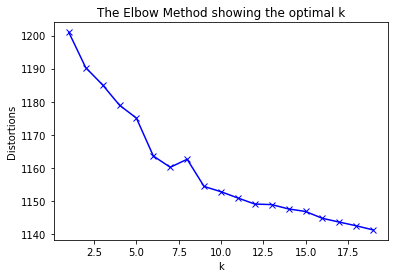

In [36]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

Sum_of_squared_distances = []
X = reviews_vec
K = range(1,20)

distortions = []
for k in K: 
    kmeans = KMeans(n_clusters = k, init = 'k-means++', max_iter = 100, n_init = 1, random_state = 42)
    kmeans.fit(X) 
    distortions.append(kmeans.inertia_)
    
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortions')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [37]:
from wordcloud import WordCloud

def wordcloud_plt(k, subplt_row, subplt_col):
    model = KMeans(n_clusters = k, init = 'k-means++', max_iter = 100, n_init = 1, random_state = 42)
    model.fit(X)
    df['cluster'] = model.labels_

    print("Top words per cluster:")
    order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    words = tfv.get_feature_names_out()

    for i in range(k):
        print('Cluster', i , ': ' + ', '.join(words[ind] for ind in order_centroids[i, :10]))
        
    fig,axs = plt.subplots(subplt_row, subplt_col, figsize = (40,15))
    h, v = 0, 0

    for i in range(k):
        s = df[df['cluster'] == i]
        text = s['review_txt'].str.cat(sep=' ')
        text = text.lower()
        text = ' '.join([word for word in text.split()])
        wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
        axs[h, v].imshow(wordcloud, interpolation="bilinear")
        axs[h, v].set_title('Cluster: {}'.format(i))
        axs[h, v].axis('off')
        if v == subplt_col-1:
            h += 1
            v = -1
        v += 1
    plt.tight_layout

### k = 7

Top words per cluster:
Cluster 0 : film, good, marvel, films, great, story, best, really, just, watch
Cluster 1 : guardians, galaxy, vol, film, movie, ego, great, groot, characters, yondu
Cluster 2 : movie, just, story, acting, marvel, great, movies, characters, bad, boring
Cluster 3 : shang, chi, rings, movie, mcu, fight, simu, liu, story, marvel
Cluster 4 : movie, like, marvel, just, good, movies, really, watch, story, great
Cluster 5 : spider, man, home, movie, way, film, peter, holland, tom, best
Cluster 6 : strange, movie, time, multiverse, film, thanos, doctor, just, wanda, marvel


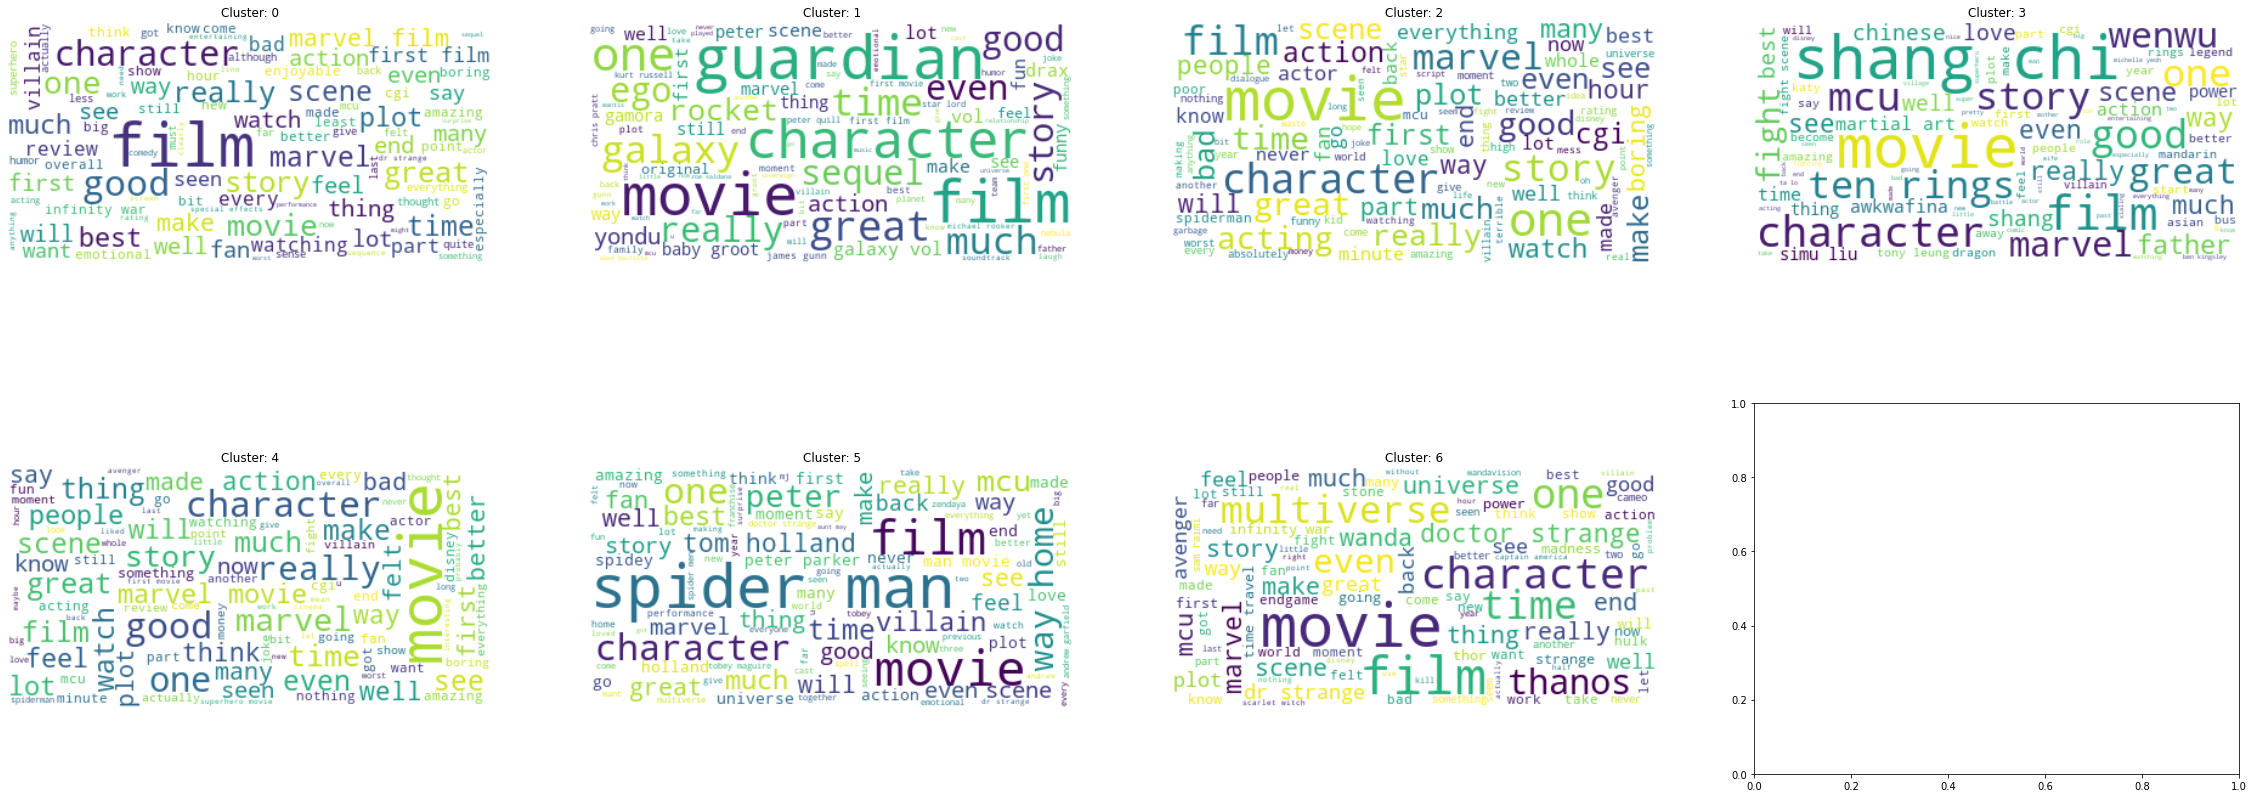

In [38]:
wordcloud_plt(7, 2, 4)

### k = 10

Top words per cluster:
Cluster 0 : half, film, movie, hour, scenes, second, watch, best, cut, emotional
Cluster 1 : film, good, marvel, really, great, plot, just, like, films, felt
Cluster 2 : movie, great, good, mcu, story, best, amazing, action, really, marvel
Cluster 3 : movie, just, marvel, like, movies, bad, good, really, watch, story
Cluster 4 : spider, man, home, movie, way, film, peter, holland, tom, best
Cluster 5 : thanos, time, infinity, war, travel, movie, avengers, captain, just, thor
Cluster 6 : shang, chi, movie, rings, chinese, marvel, martial, fight, mcu, arts
Cluster 7 : guardians, galaxy, vol, movie, film, groot, ego, great, characters, yondu
Cluster 8 : strange, multiverse, doctor, movie, wanda, dr, madness, film, raimi, like
Cluster 9 : disney, movie, marvel, like, good, bad, story, film, watch, money


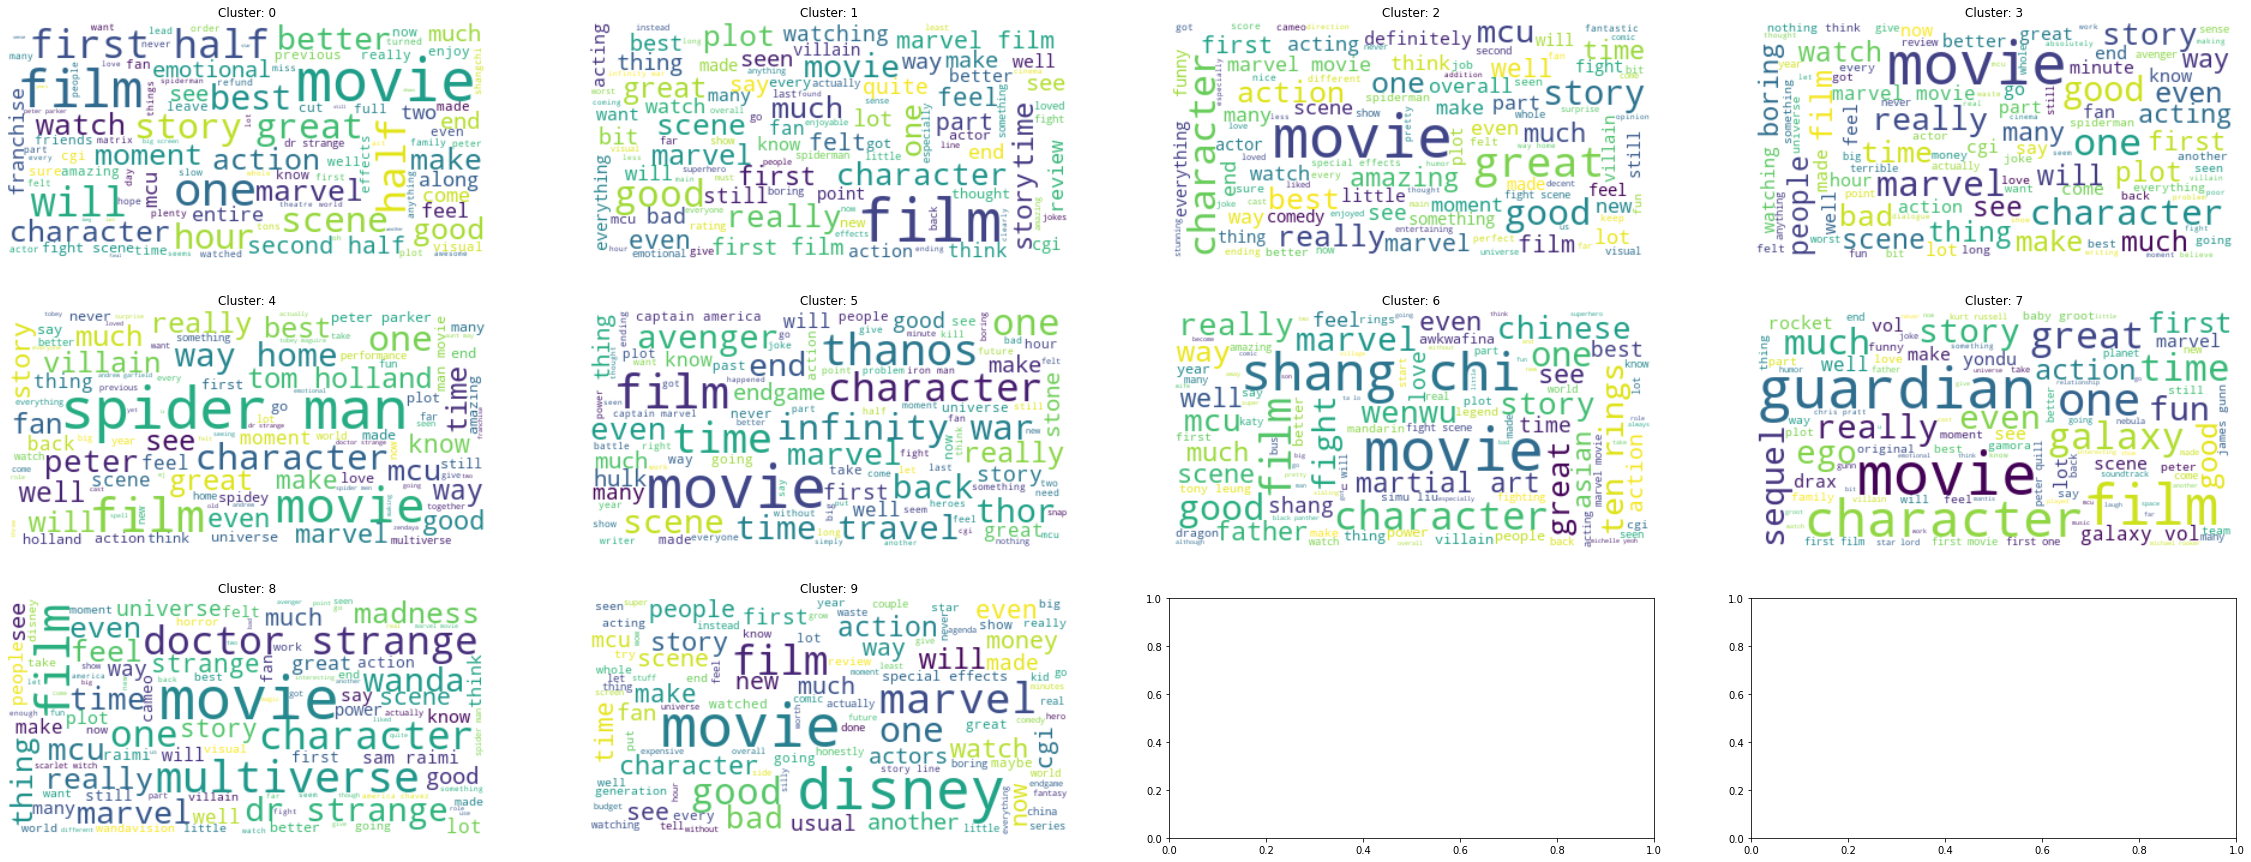

In [39]:
wordcloud_plt(10, 3, 4)

### k = 17

Top words per cluster:
Cluster 0 : half, hour, cut, second, unimportant, refund, friends, slow, scenes, 3h
Cluster 1 : film, good, woke, plot, just, feel, felt, like, cheesier, drax
Cluster 2 : movie, great, good, amazing, mcu, story, really, action, marvel, scenes
Cluster 3 : movie, like, bad, boring, marvel, just, really, end, thing, action
Cluster 4 : spider, man, home, movie, way, film, holland, peter, tom, best
Cluster 5 : thanos, time, travel, movie, captain, avengers, thor, hulk, infinity, endgame
Cluster 6 : movie, just, marvel, like, movies, good, really, don, way, character
Cluster 7 : guardians, movie, galaxy, film, fun, groot, great, vol, characters, yondu
Cluster 8 : strange, multiverse, doctor, movie, wanda, dr, madness, raimi, film, like
Cluster 9 : disney, movie, marvel, bad, movies, money, like, watch, good, agenda
Cluster 10 : guardians, galaxy, vol, film, quill, ego, movie, rocket, groot, funny
Cluster 11 : shang, chi, rings, wenwu, movie, story, legend, simu, fight,

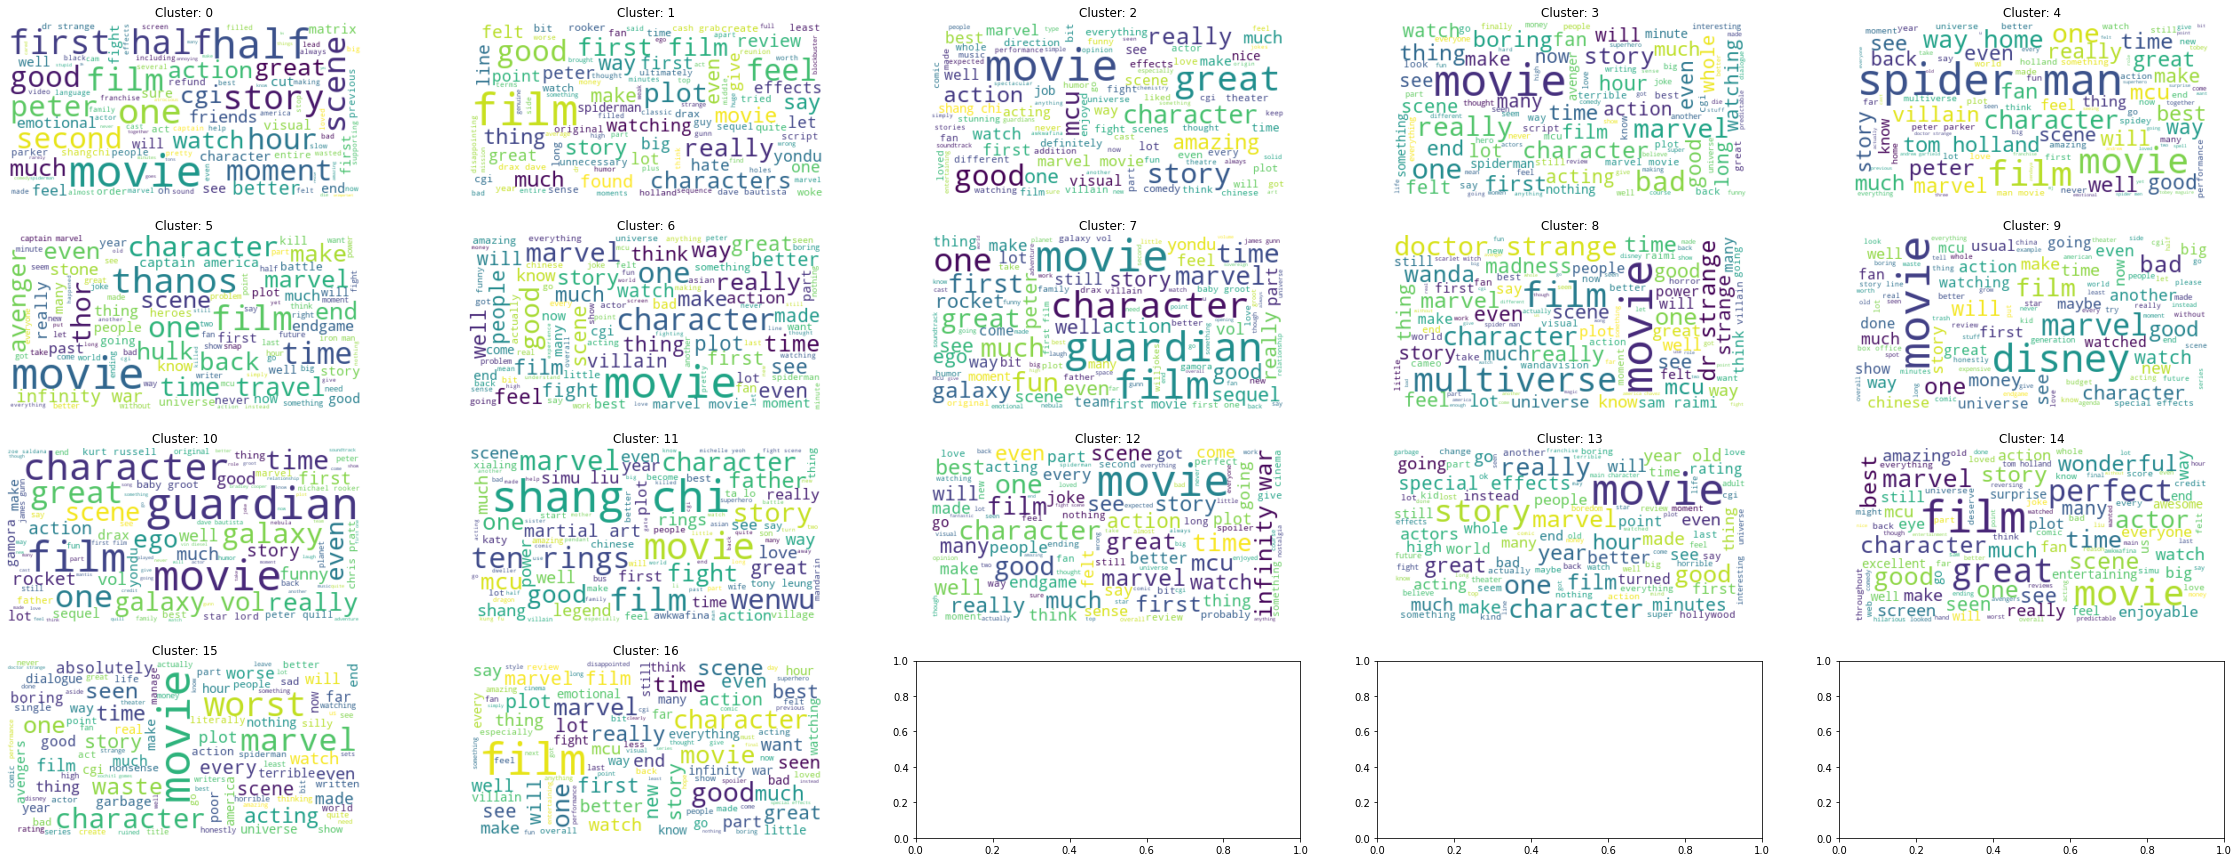

In [40]:
wordcloud_plt(17, 4, 5)

#### **2)** Try to write a short phrase to characterize (give a natural interpretation of) what each cluster is generally centered on semantically. Is this hard to do in some cases? If so, make note of that fact. 

In looking at the clusters defined above we see the following:

With K=5, there doesn't seem to be any real definition of what the centroid is centered on. All of the clusters have the words film and movie in them which could be center points. The clusters themselves don't make a whole lot of sense

With K=10, we do start to see that the clusters start to cluster around commonalities in specific movies. For example, Cluster 0 seems to indicate word attributes based on the movie "Heat" starring Al Pacino and Robert De Niro. Similar results are seen in Cluster 8, which seems to be focused on the movie "The Machinist" starring Christian Bale. On the flip side certain clusters don't look to good. Cluster 9 is one of these. It looks just like a random sampling of words.

With K=20, we start to see a continuation of the clusters around commonalities to specific movies. We also start to see similar movie items start to be clustered together. For example, Cluster 18 seems to focus in on the movie "The Hunt for Red October". We also do see some "odd" clusters that don't really provide key information. For example Cluster 14 is just a bunch of random words that define a movie in general.

#### **3)** Explain which of the two clustering results from question 1 is preferable (if one of them is), and why. 